# Movielens 영화 SBR

Movielens 1M Dataset을 기반으로,  
Session based Recommendation 시스템을 구현하고 실험한다.


### 최종 실험 결과 해석

- Recall@20: 0.090909
- MRR@20: 0.018398

여러 실험 결과를 비교한 결과,  
기본 세션 정의, epochs=3, 기본 하이퍼파라미터 설정이 가장 높은 성능을 보여주었다.

이는 모델이 과도하게 복잡하지 않고, 적절한 학습 횟수와 안정된 세션 구성에서 가장 효과적으로 패턴을 학습했음을 의미한다.

기본 설정이 현재 데이터와 모델 구조에 가장 잘 맞는 최적 조합이었으며, 불필요한 조정은 오히려 성능 저하를 유발할 수 있음을 확인하였다.

## 0. 데이터 로드

In [1]:
import pandas
import tensorflow

print(pandas.__version__)
print(tensorflow.__version__)

1.3.3
2.6.0


In [2]:
import datetime as dt
from pathlib import Path
import os
import time
from datetime import datetime
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    # time 형식을 기존과 맞게 고쳐보기
    data['Time'] = pd.to_datetime(data['Time'], unit='s')
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


<br>

### +) Session 단위 정의 변경 실험

- 세션 단위를 사용자(UserId) + 일정 시간 간격으로 정의
- 세션 길이 분석
- 세션 간 시간 간격 시각화

In [14]:
# # 세션 정의: 유저별 30분 이상 간격이면 새로운 세션 시작
# data['SessionId'] = (data['Time'].diff() > pd.Timedelta(minutes=30)).cumsum()

# # 세션 길이 분석
# session_lengths = data.groupby('SessionId').size()
# print(session_lengths.describe())

count    19157.00000
mean        52.21115
std        134.86996
min          1.00000
25%          1.00000
50%          3.00000
75%         32.00000
max       2411.00000
dtype: float64


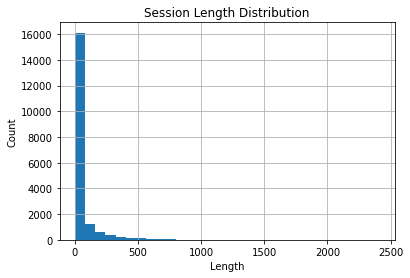

In [15]:
# # 세션 간 시간 간격 시각화
# import matplotlib.pyplot as plt
# session_lengths.hist(bins=30)
# plt.title("Session Length Distribution")
# plt.xlabel("Length")
# plt.ylabel("Count")
# plt.show()

<br>
<br>

## 1. 데이터 전처리

### 1.1 &nbsp;Data Cleansing

In [4]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있음
# 이를 위해 반복문을 통해 지속적으로 제거
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [5]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [6]:
# 1) 세션 길이 분포 확인
print("검증 세션 수:", data['UserId'].nunique())
print("세션별 길이(상위 10개):")
print(data.groupby('UserId').size().sort_values(ascending=False).head(10))

# 2) 길이 1인 세션 개수
print("길이 1 세션 비율:",
      (data.groupby('UserId').size() == 1).mean())

검증 세션 수: 6040
세션별 길이(상위 10개):
UserId
4169    2277
1680    1850
4277    1740
1941    1594
1181    1521
889     1514
3618    1342
2063    1320
1150    1299
1015    1285
dtype: int64
길이 1 세션 비율: 0.0


<br>

### 1.2 &nbsp;Train / Valid / Test split

In [7]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    cutoff_time = final_time - dt.timedelta(days=n_days)

    # Train: cutoff 이전의 데이터
    train = data[data['Time'] < cutoff_time]

    # Test: cutoff 이후의 데이터, 단 아이템은 train에 있던 것만
    test = data[(data['Time'] >= cutoff_time) & (data['ItemId'].isin(train['ItemId']))]

    return train, test

In [8]:
tr, test = split_by_date(data, n_days=14)  # 마지막 이틀만 테스트용으로 분리
tr, val = split_by_date(tr, n_days=14)  # 마지막 이틀만 테스트용으로 분리

In [9]:
# data에 대한 정보를 살펴보기
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

<br>

클렌징을 추가로 진행한다.

In [10]:
tr = cleanse_recursive(tr, shortest=2, least_click=5)
val = cleanse_recursive(val, shortest=2, least_click=1)
test = cleanse_recursive(test, shortest=2, least_click=1)

In [11]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 998112
	 Sessions: 6040
	 Items: 3416
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2003-01-31 12:16:30

* valid Set Stats Info
	 Events: 883
	 Sessions: 39
	 Items: 692
	 First Time : 2003-01-31 17:23:06
	 Last Time : 2003-02-14 02:02:32

* test Set Stats Info
	 Events: 575
	 Sessions: 44
	 Items: 489
	 First Time : 2003-02-15 00:15:09
	 Last Time : 2003-02-28 17:49:50



In [12]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [13]:
# 1) 세션 길이 분포 확인
print("검증 세션 수:", val['UserId'].nunique())
print("세션별 길이(상위 10개):")
print(val.groupby('UserId').size().sort_values(ascending=False).head(10))

# 2) 길이 1인 세션 개수
print("길이 1 세션 비율:",
      (val.groupby('UserId').size() == 1).mean())

검증 세션 수: 39
세션별 길이(상위 10개):
UserId
398     220
3012    165
4958    133
419      79
5654     72
5172     61
195      13
4312     12
2648     12
3732     11
dtype: int64
길이 1 세션 비율: 0.0


In [14]:
tr

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
...,...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29,1248
999988,6040,1921,4,2001-08-10 14:41:04,370
1000172,6040,1784,3,2001-08-10 14:41:04,89
1000167,6040,161,3,2001-08-10 14:41:26,464


<br>
<br>

## 2. 미니 배치 구성

### 2.1 &nbsp;SessionDataset

데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스를 만든다.

In [15]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

train 데이터로 SessionDataset 객체를 만들고 인스턴스 변수들을 살펴본다.  

click_offsets 변수는 각 세션이 시작된 인덱스를 담고 있다.  
session_idx 변수는 각 세션을 인덱싱한 np.array다.

In [16]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [17]:
tr_dataset.click_offsets

array([     0,     53,    182, ..., 997648, 997771, 998112], dtype=int32)

In [18]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 6037, 6038, 6039])

In [19]:
start = tr_dataset.click_offsets[tr_dataset.session_idx[[[0,1,2,3]]]]       # data 상에서 session이 시작된 위치를 가져옵니다.
end = tr_dataset.click_offsets[tr_dataset.session_idx[[0,1,2,3]] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.

start
end

array([ 53, 182, 233, 254], dtype=int32)

In [20]:
(end - start).min() -1

20

In [21]:
inp = tr_dataset.df['item_idx'].values[start + 20]
inp

array([ 20,  71, 185,  88])

In [22]:
target = tr_dataset.df['item_idx'].values[start + 20 + 1]
target

array([ 21,  72, 186,  56])

<br>

### 2.2 &nbsp;SessionDataLoader

In [23]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""


    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        
        # batch_size 를 마지막에 남은 부분을 처리
        self.batch_size = min(batch_size, len(dataset.session_idx))

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옴
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옴
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옴
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):
        # 다음 배치 데이터를 생성하기 위해 상태를 update

        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줌
        mask = np.arange(self.batch_size)[(end - start) == 1]
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻 -> mask에 기록

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌 것
            new_session = last_session + i
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치 기록
        return start, end, mask, last_session, finished

In [24]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [25]:
iter_ex = iter(tr_data_loader)

# 반복 실행하면 next가 계속 다음 데이터를 만듦
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 65 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


<br>
<br>

## 3. 모델 구성

### 3.1 &nbsp;Evaluation Metric

Session-Based Recommendation Task에서는 모델이 k개의 아이템을 제시했을 때, 유저가 클릭/구매한 n개의 아이템이 많아야 좋다.

이 때문에 recall의 개념을 확장한 `recall@k` 지표, precision의 개념을 확장한 `Mean Average Precision@k` 지표 등을 사용한다.

추천에서는 몇 번째로 맞추느냐도 중요하다. 구글에서 검색했을 때 1페이지에 원하는 결과가 나오지 않고 2페이지에 나온다면 유저 반응이 크게 떨어질 것이다. 따라서 순서에 민감한 지표인 `MRR`, `NDCG` 같은 지표도 사용합니다.

해당 데이터에서는 `MRR` 과 `Recall@k` 를 사용하겠다.  
MRR은 정답 아이템이 나온 순번의 역수 값이다. 따라서 정답 아이템이 추천 결과 앞쪽 순번에 나온다면 지표가 높아질 것이고 뒤쪽에 나오거나 안 나온다면 지표가 낮아질 것이다.

In [26]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

<br>

### 3.2 &nbsp;Model Architecture

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [28]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [29]:
# 모델에 사용할 hyper-parameter를 class형식으로 관리
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

In [30]:
# 배치사이즈를 너무 크게두면 평가 부분에서 nan이 나옴  
args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

#### 하이퍼파라미터 변경 실험

In [45]:
# # 실험 3-1. hidden size 증가
# args = Args(tr, val, test, batch_size=256, hsz=100, drop_rate=0.1, lr=0.001, epochs=3, k=20)

# # 실험 3-2. dropout 비율 증가 & learning rate 감소
# args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.3, lr=0.0005, epochs=3, k=20)

In [31]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(256, 1, 3416)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    520200    
_________________________________________________________________
dropout (Dropout)            (256, 50)                 0         
_________________________________________________________________
dense (Dense)                (256, 3416)               174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


<br>

## 4. 모델 학습 및 테스트

다양한 하이퍼파라미터를 변경하면서 테스트셋에 대해서 어느 정도 성능을 내는지 검증한다.

- 참고) 배치 사이즈나 epoch 등의 설정은 위의 args에서 관리함


In [32]:
# train 셋으로 학습하면서 valid 셋으로 검증
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    tf.config.run_functions_eagerly(True)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화 -> 아래 메서드에서 확인

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옴
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옴
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가
                                                     # train과 거의 같지만 mrr, recall을 구하는 라인이 있음
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()

    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1) 
        # 
        if input_ohe.shape[0] < args.batch_size:
            pad_len = args.batch_size - input_ohe.shape[0]
            padding = np.zeros((pad_len, 1, args.num_items))
            input_ohe = np.concatenate([input_ohe, padding], axis=0)

        pred = model.predict(input_ohe, batch_size=args.batch_size)


        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])
    
    
    print(recall_list)
    print(mrr_list)
    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

### 0. 기본 세션 정의 + epochs=3 + 기존 하이퍼파라미터


In [33]:
train_model(model, args)

Evaluation:  33%|███▎      | 1/3 [00:00<00:00,  4.78it/s]


[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0.25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.058823529411764705, 0, 0, 0, 0, 0, 0, 0, 0.25, 0, 0, 0, 0, 0, 0, 0, 0.05263157894736842, 0, 0, 0]
	 - Recall@20 epoch 1: 0.102564
	 - MRR@20    epoch 1: 0.015678



Evaluation:  33%|███▎      | 1/3 [00:00<00:00,  4.98it/s]


[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0.0625, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.09090909090909091, 0, 0, 0, 0, 0.05263157894736842, 0, 0, 0, 0, 0, 0, 0, 0.3333333333333333, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	 - Recall@20 epoch 2: 0.102564
	 - MRR@20    epoch 2: 0.013830



Evaluation:  33%|███▎      | 1/3 [00:00<00:00,  5.13it/s]

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0.09090909090909091, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.16666666666666666, 0, 0, 0, 0, 0.058823529411764705, 0, 0, 0, 0, 0, 0, 0, 0.14285714285714285, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	 - Recall@20 epoch 3: 0.102564
	 - MRR@20    epoch 3: 0.011776



#### Model Test

In [34]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s]

[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0.14285714285714285, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.16666666666666666, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.25, 0, 0, 0.25, 0, 0, 0]
	 - Recall@20: 0.090909
	 - MRR@20: 0.018398



<br>

### 실험 1. 세션 정의 방식 변경

기존에는 UserId 단위로 세션을 구성했으나,  
해당 실험에서는 30분 이상 시간 간격 발생 시 새로운 세션으로 정의하였다.

#### Model Training

In [48]:
train_model(model, args)

Evaluation:  33%|███▎      | 1/3 [00:00<00:00,  4.63it/s]


[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0.08333333333333333, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.05263157894736842, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	 - Recall@20 epoch 1: 0.076923
	 - MRR@20    epoch 1: 0.016307



Evaluation:  33%|███▎      | 1/3 [00:00<00:00,  5.10it/s]


[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1111111111111111, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.3333333333333333, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	 - Recall@20 epoch 2: 0.076923
	 - MRR@20    epoch 2: 0.037037



Evaluation:  33%|███▎      | 1/3 [00:00<00:00,  4.86it/s]

[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0.05263157894736842, 0, 0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.14285714285714285, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.14285714285714285, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	 - Recall@20 epoch 3: 0.102564
	 - MRR@20    epoch 3: 0.034317



#### Model Test


In [49]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  50%|█████     | 1/2 [00:00<00:00,  4.28it/s]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.07142857142857142, 0, 0, 0]
	 - Recall@20: 0.022727
	 - MRR@20: 0.001623



Recall@20, MRR@20 모두 하락한 것을 볼 수 있다.

세션이 과도하게 쪼개지면서 충분한 길이의 시퀀스를 확보하지 못하고, RNN이 이전 아이템 패턴을 학습할 문맥 정보가 부족해져  결과적으로 모델이 다음 아이템을 예측하기 어려워진 것으로 예상할 수 있다.

시간 기반 세션 분할은 데이터의 특성과 모델 구조를 고려해 신중하게 적용해야 하고,  
UserId 단위 세션 유지가 해당 데이터셋에서는 더 적합하다고 판단된다.



<br>

### 실험 2. epochs=10

모델 학습 epoch 수를 증가시켰을 때의 성능 변화 확인

#### Model Training

In [32]:
train_model(model, args)

Evaluation:  33%|███▎      | 1/3 [00:00<00:00,  4.65it/s]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	 - Recall@20 epoch 1: 0.025641
	 - MRR@20    epoch 1: 0.012821



Evaluation:  33%|███▎      | 1/3 [00:00<00:00,  4.89it/s]


[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0.125, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.07142857142857142, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.14285714285714285, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	 - Recall@20 epoch 2: 0.076923
	 - MRR@20    epoch 2: 0.008700



Evaluation:  33%|███▎      | 1/3 [00:00<00:00,  5.00it/s]


[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0.09090909090909091, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.08333333333333333, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	 - Recall@20 epoch 3: 0.076923
	 - MRR@20    epoch 3: 0.009596



Evaluation:  33%|███▎      | 1/3 [00:00<00:00,  4.94it/s]


[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0.2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.08333333333333333, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.14285714285714285, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	 - Recall@20 epoch 4: 0.076923
	 - MRR@20    epoch 4: 0.010928



Evaluation:  33%|███▎      | 1/3 [00:00<00:00,  4.74it/s]


[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0.14285714285714285, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.06666666666666667, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.125, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	 - Recall@20 epoch 5: 0.076923
	 - MRR@20    epoch 5: 0.008578



Evaluation:  33%|███▎      | 1/3 [00:00<00:00,  4.84it/s]


[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0.125, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.05263157894736842, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.125, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	 - Recall@20 epoch 6: 0.076923
	 - MRR@20    epoch 6: 0.007760



Evaluation:  33%|███▎      | 1/3 [00:00<00:00,  4.86it/s]


[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0.09090909090909091, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.05, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	 - Recall@20 epoch 7: 0.076923
	 - MRR@20    epoch 7: 0.006177



Evaluation:  33%|███▎      | 1/3 [00:00<00:00,  4.89it/s]


[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0.07142857142857142, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.07692307692307693, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	 - Recall@20 epoch 8: 0.051282
	 - MRR@20    epoch 8: 0.003804



Evaluation:  33%|███▎      | 1/3 [00:00<00:00,  4.86it/s]


[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0.05, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	 - Recall@20 epoch 9: 0.025641
	 - MRR@20    epoch 9: 0.001282



Evaluation:  33%|███▎      | 1/3 [00:00<00:00,  4.77it/s]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.05555555555555555, 0, 0]
	 - Recall@20 epoch 10: 0.025641
	 - MRR@20    epoch 10: 0.001425



#### Model Test

In [33]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  50%|█████     | 1/2 [00:00<00:00,  4.39it/s]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0625, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0, 0, 0.0625, 0, 0, 0]
	 - Recall@20: 0.068182
	 - MRR@20: 0.005114



기존 epochs=3에서 epochs=10으로 조정 후 성능 비교

학습 과정
- train_loss는 6.57 → 5.84로 감소
- accuracy는 0.01대 → 0.05대로 상승
- Recall@20은 4 epoch까지 소폭 상승하다가 정체
- MRR@20은 계속 하락

epochs=10으로 학습을 오래 시킨 결과, Recall@20은 증가했지만 MRR@20은 하락하였다. 이는 정답을 더 많이 맞추긴 했지만, 정답을 상위에 배치하는 데 실패했음을 의미한다. 

순위 기반 지표(MRR)를 중요하게 보는 추천 시스템에서는 적절한 epoch 조절이 중요하다는 인사이트를 얻을 수 있다.



<br>

### 실험 3. 하이퍼파라미터 변경

3.1 hidden size 증가

#### Model Training

In [35]:
train_model(model, args)

Evaluation:  33%|███▎      | 1/3 [00:00<00:00,  4.80it/s]


[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0.0625, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0, 0, 0, 0, 0.05263157894736842, 0, 0, 0, 0, 0, 0, 0, 0.25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	 - Recall@20 epoch 1: 0.102564
	 - MRR@20    epoch 1: 0.011926



Evaluation:  33%|███▎      | 1/3 [00:00<00:00,  5.07it/s]


[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0.0625, 0, 0, 0.0625, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.16666666666666666, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	 - Recall@20 epoch 2: 0.102564
	 - MRR@20    epoch 2: 0.012607



Evaluation:  33%|███▎      | 1/3 [00:00<00:00,  4.83it/s]

[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0.05555555555555555, 0, 0, 0.08333333333333333, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.14285714285714285, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	 - Recall@20 epoch 3: 0.102564
	 - MRR@20    epoch 3: 0.009788



#### Model Test

In [36]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  50%|█████     | 1/2 [00:00<00:00,  4.32it/s]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.058823529411764705, 0, 0, 0]
	 - Recall@20: 0.022727
	 - MRR@20: 0.001337



Recall@20, MRR@20 모두 하락한 것을 볼 수 있다.

hidden size가 커지면서 모델 복잡도는 증가했지만, 데이터 규모나 패턴에 비해 과적합 발생 가능성이 있어 일반화 성능은 오히려 저하되었다고 해석할 수 있다.

데이터 특성에 맞는 적절한 hidden size 선택이 필요하다.

<br>

3.2 dropout 비율 증가 & learning rate 감소

#### Model Training

In [48]:
train_model(model, args)

Evaluation:  33%|███▎      | 1/3 [00:00<00:00,  4.60it/s]


[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0.06666666666666667, 0.05, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	 - Recall@20 epoch 1: 0.051282
	 - MRR@20    epoch 1: 0.002991



Evaluation:  33%|███▎      | 1/3 [00:00<00:00,  4.94it/s]


[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 0.25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.058823529411764705, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0.05555555555555555, 0, 0]
	 - Recall@20 epoch 2: 0.102564
	 - MRR@20    epoch 2: 0.022164



Evaluation:  33%|███▎      | 1/3 [00:00<00:00,  5.07it/s]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.09090909090909091, 0, 0, 0, 0, 0, 0, 0, 0.3333333333333333, 0, 0, 0, 0, 0, 0, 0, 0.05555555555555555, 0.0625, 0, 0]
	 - Recall@20 epoch 3: 0.102564
	 - MRR@20    epoch 3: 0.013905



#### Model Test

In [49]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  50%|█████     | 1/2 [00:00<00:00,  4.40it/s]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.09090909090909091, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	 - Recall@20: 0.022727
	 - MRR@20: 0.002066



Recall@20, MRR@20이 모두 하락한 것을 볼 수 있다.

Dropout 비율 증가  
→ 과도한 드롭아웃으로 학습 중 정보 손실이 커짐  
→ 충분한 패턴 학습이 어려워짐  

Learning rate 감소  
→ 학습 속도가 느려져, 제한된 epoch 안에 최적값에 도달하지 못함  


정규화와 학습률은 적절한 수준에서 조절되어야 하고, 과도한 억제는 오히려 학습 부족을 초래할 수 있다.